## Общее описание:

Команда внедрила в приложение по доставке продуктов умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен A/B-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения.

## Описание данных

Для анализа A/B-теста будем использовать следующие данные:

* **ab_users_data** – история заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи
    
* **ab_orders** -  подробная информация о составе заказа, для каждого заказа есть список id тех продуктов, которые были включены в заказ
   
* **ab_products** – подробная информация о продуктах, их название и стоимость

## План

1. **Сначала сделаем небольшой препроцессинг:**
    - Посмотрим на данные
    - Сделаем необходимые преобразования
2. **Проводим анализ:**
    - Выбираем метрики
    - Формулируем гипотезы
    - Строим графики
    - Выбираем подходящий тест
    - Тестируем
3. **Подводим итоги:**
    - Сформулируем выводы
    - Как можно будет позже провести A/B тестирование?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, shapiro, ttest_ind, bootstrap
sns.set(rc={'figure.figsize':(15, 5)}, style="whitegrid")

## Считывание и анализ данных

In [2]:
df_users = pd.read_csv('ab_users_data.csv')
df_products = pd.read_csv('ab_products.csv')
df_orders = pd.read_csv('ab_orders.csv')

### Датафрейм df_users

In [3]:
df_users.head()

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1


In [4]:
df_users.shape

(4337, 6)

In [5]:
df_users.isna().sum()

user_id     0
order_id    0
action      0
time        0
date        0
group       0
dtype: int64

In [6]:
df_users.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

Преобразуем типы данных столбцов **time** и **date** к типу данных datetime

In [7]:
df_users['time'] = df_users.time.astype('datetime64')
df_users['date'] = df_users.date.astype('datetime64')

Посмотрим есть ли в столбце **date** даты, которые были позднее, чем даты в столбце **time**

In [8]:
df_users.query('date > time').shape[0]

0

Получается, что столбец **date** дублирует столбец **time**, оставляя дату без времени

In [9]:
df_users.nunique()

user_id     1017
order_id    4123
action         2
time        4312
date          14
group          2
dtype: int64

Посмотрим на уникальные значения столбца **action**

In [10]:
df_users.action.unique()

array(['create_order', 'cancel_order'], dtype=object)

В столбце **action** наблюдается два значения: создание заказа и отмена заказа

Посмотрим на количество уникальных пользователей, количество заказов и количество отменённых заказов в разбивке по группе A/B-теста

In [11]:
df_users.groupby(['group'], as_index=False)\
         .agg(unique_users_count=('user_id', lambda x: len(x.unique())),
             orders_count=('order_id', 'count'),
             cancel_order_count=('action', lambda x: (x == 'cancel_order').sum()))     

,group,unique_users_count,orders_count,cancel_order_count
0,0,515,1691,82
1,1,502,2646,132


### Датафрейм  df_orders

In [12]:
df_orders.head()

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"


In [13]:
df_orders.shape

(4123, 3)

In [14]:
df_orders.isna().sum()

order_id         0
creation_time    0
product_ids      0
dtype: int64

In [15]:
df_orders.nunique()

order_id         4123
creation_time    4098
product_ids      3877
dtype: int64

In [16]:
df_orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

Преобразуем тип данных столбца **creation_time** к типу данных **datetime**

In [17]:
df_orders['creation_time'] = df_orders.creation_time.astype('datetime64')

В столбце **product_ids** записаны данные похожие на множество (тип данных **set**), но чтобы не проверять это, преобразуем тип данного столбца к отсортированному списку **list**

In [18]:
df_orders['product_ids'] = df_orders.product_ids\
                                    .apply(lambda x: sorted(x[1:-1].split(', ')))

### Датафрейм df_products

In [19]:
df_products.head()

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0


In [20]:
df_products.shape

(87, 3)

In [21]:
df_products.isna().sum()

product_id    0
name          0
price         0
dtype: int64

In [22]:
df_products.dtypes

product_id      int64
name           object
price         float64
dtype: object

In [23]:
df_products.nunique()

product_id    87
name          87
price         63
dtype: int64

### Вывод по анализу:

1. Для анализа A/B-теста есть следующие датафреймы: 

    - **df_users** - история заказов пользователей:
        * user_id - идентификационный номер пользователя
        * order_id - идентификационный номер заказа
        * action - действие с заказом
            - create_order - заказ создан
            - cancel_order - заказ отменён
        * time - дата и время взаимодействия пользователя с приложением
        * date - дата взаимодействия пользователя с приложением
        * group - группа A/B-теста
            - 0 - контрольная группа (A)
            - 1 - тестовая группа (B)

    - **df_orders** - подробная информация о составе заказа:
        * order_id - идентификационный номер заказа
        * creation_time - дата и время создания заказа
        * product_ids - список идентификационных номеров товаров

    **df_products** - подробная информация о товарах:
        * product_id - идентификационный номер товара
        * name - наименование товара
        * price - цена товара
- В контрольной группе наблюдается 515 уникальных пользователей, в тестовой - 502       
- В контрольной группе наблюдается 1691 созднаный заказ, в тестовой - 2646
- В контрольной группе наблюдается 82 отмены заказа, в тестовой - 132

## Гипотезы и тесты

Введём метрику количества заказов на одного пользователя Orders Count per User (**OCU**)

**H0** - нет статистически значимых различий в распределениях количества заказов на одного пользователя между тестовой и контрольной группами.

**H1** -  существуют статистически значимые различия в распределениях количества заказов на одного пользователя между тестовой и контрольной группами.

In [24]:
df_metrics = df_users.query('action == "create_order"')\
                .groupby(['group', 'user_id'], as_index=False)\
                .agg(OCU=('order_id', 'count'))

Построим графики распредления **OCU**. 

*учитывая, что нам понадобится визуализировать распределения других метрик, создадим фунцию построения необходимых графиков*

In [25]:
def show_plots(df, metric):
    '''Строит гистограмму и боксплоты распределения заданной метрики'''
    sns.set(style="ticks", font_scale=0.8)
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(hspace=0.7)
    sns.histplot(data=df, x=metric, hue='group', kde=False, palette='YlOrBr', ax=axs[0])
    axs[0].set_title(f'Распределение {metric} в тестовой и контрольной группах')
    axs[0].set_xlabel(f'{metric}')
    axs[0].set_ylabel('Количество')
    axs[0].tick_params(axis='both', which='both', labelsize=8)
    sns.boxplot(data=df, x ='group', y=metric, palette='YlOrBr', ax=axs[1])
    axs[1].set_title(f'Распределение {metric} в тестовой и контрольной группах')
    axs[1].set_xlabel('Группа')
    axs[1].set_ylabel(f'{metric}')
    axs[1].tick_params(axis='both', which='both', labelsize=8)
    plt.show()

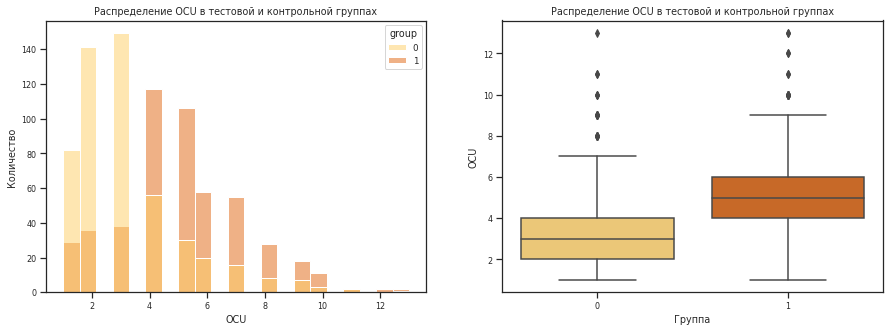

In [26]:
show_plots(df_metrics, 'OCU')

Для проверки на наличие статистически значимых различий в выборках, проверим распределения на нормальность с помощью критерия Шапиро-Уилка

*Учитывая, что нам и далее понадобится определять нормальность распределений, создадим фунции*

In [27]:
def make_groups(df, metric):
    control_group = df.query('group == 0')[metric]
    test_group = df.query('group == 1')[metric]
    return control_group, test_group

In [28]:
def shapiro_test(test_group, control_group):
    print('Критейрий Шапиро-Уилка')
    print('p-value контрольной группы =', shapiro(test_group).pvalue)
    print('p-value тестовой группы =', shapiro(control_group).pvalue)
    print()
    print('Критейрий Шапиро-Уилка прологарифмированных выборок (без учёта нулевых значений)')
    print('p-value контрольной группы =', shapiro(np.log(test_group[test_group > 0])).pvalue)
    print('p-value тестовой группы =', shapiro(np.log(control_group[control_group > 0])).pvalue)

In [29]:
a, b = make_groups(df_metrics, 'OCU')
shapiro_test(a, b)

Критейрий Шапиро-Уилка
p-value контрольной группы = 1.0818117861129074e-22
p-value тестовой группы = 1.7252431427916548e-10

Критейрий Шапиро-Уилка прологарифмированных выборок (без учёта нулевых значений)
p-value контрольной группы = 1.4064806753337575e-14
p-value тестовой группы = 4.335773886995714e-18


Уровень значимости критерия Шапиро-Уилка ниже заранее заданного уровня значимости **α** (0.05), что позволяет нам отвергнуть нулевую гипотезу H0 о нормальности распределения выборок. Для определения наличия статистически значимых различий между группами, будем использовать критерий Манна-Уитни.

In [30]:
mannwhitneyu(a, b)

MannwhitneyuResult(statistic=61172.5, pvalue=6.987139829766148e-49)

Уровень значимости критерия Манна-Уитни ниже уровня значимости α (0.05), что позволяет нам отвергнуть нулевую гипотезу H0. 
Посмотрим, на сколько изменилось количество заказов на одного пользователя между тестовой и контрольной группами.

In [31]:
def metric_difference(df, metric):
    median_control = df.query('group == 0')[metric].median()
    median_test = df.query('group == 1')[metric].median()
    difference = median_test - median_control
    percent_difference = round(((difference) / median_control) * 100, 2)
    print(f'{difference}, {percent_difference} %')

In [32]:
metric_difference(df_metrics, 'OCU')

2.0, 66.67 %


### Вывод:

Имеются статистически значимые различия в количестве заказов на одного пользователя между тестовой и контрольной группами. Наблюдается увеличение на 2 заказа (66.67 %) на одного пользователя в тестовой группе по сравнению с контрольной.

### Метрика MPCO

Введём метрику среднего количества товаров в заказе на одного пользователя Mean Products Count per Order (**MPCO**)

**H0** - нет статистически значимых различий в распределениях среднего количества товаров в заказе на одного пользователя между тестовой и контрольной группами.

**H1** -  существуют статистически значимые различия в распределениях среднего количества товаров в заказе на одного пользователя между тестовой и контрольной группами.

Уровень значимости **α** = 0.05

In [33]:
df_users_orders = df_users.merge(df_orders, on='order_id', how='outer')\
                          .sort_values('product_ids', key= lambda x: x.str.len())

df_MPCO = df_users_orders.query('action == "create_order"')\
                        .groupby(['group', 'user_id'], as_index=False)\
                        .agg(MPCO=('product_ids', lambda x: np.mean(x.str.len())))
df_metrics = df_metrics.merge(df_MPCO, on=['group', 'user_id'])

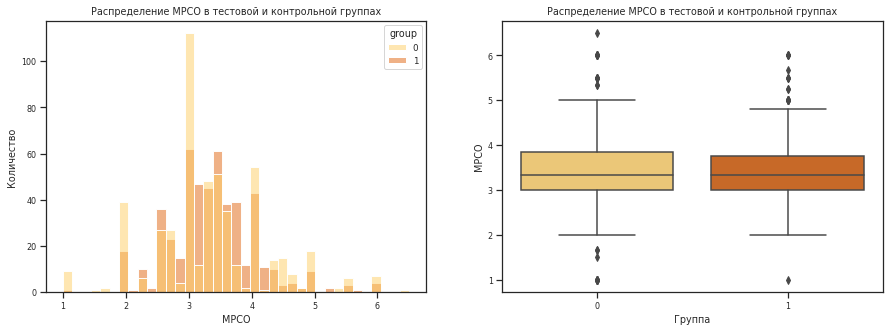

In [34]:
show_plots(df_metrics, 'MPCO')

In [35]:
a, b = make_groups(df_metrics, 'MPCO')
shapiro_test(a, b)

Критейрий Шапиро-Уилка
p-value контрольной группы = 2.9056350658862584e-09
p-value тестовой группы = 1.15523279831109e-09

Критейрий Шапиро-Уилка прологарифмированных выборок (без учёта нулевых значений)
p-value контрольной группы = 7.476215606745098e-16
p-value тестовой группы = 3.6085865406931816e-09


Уровень значимости критерия Шапиро-Уилка ниже заранее заданного уровня значимости α (0.05), что позволяет нам отвергнуть нулевую гипотезу H0. Для определения наличия статистически значимых различий между группами, мы будем использовать критерий Манна-Уитни.

In [36]:
mannwhitneyu(a, b)

MannwhitneyuResult(statistic=125211.0, pvalue=0.38508959507477036)


### Вывод:
Уровень значимости, полученный с помощью критерия Манна-Уитни, равен 0.385, что выше выбранного уровня значимости α (0.05), не позволяет нам отклонить нулевую гипотезу H0. В выборках нет статистически значимых различий в среднем количестве товаров в заказе на одного пользователя между тестовой и контрольной группами.


### Метрика TMU

Введём метрику количества прибыли от каждого пользователя Total Money per User (**TMU**)

**H0** - нет статистически значимых различий в количестве прибыли от одного пользователя между тестовой и контрольной группами.

**H1** -  существуют статистически значимые различия  в количестве прибыли от одного пользователя между тестовой и контрольной группами.

Уровень значимости **α** = 0.05

Разобьём список в столбце **product_ids** датафрейма **df_users_orders** с помощью метода **explode**

In [37]:
users_orders = df_users_orders.explode('product_ids')\
                              .reset_index(drop=True)\
                              .rename(columns={'product_ids': 'product_id'})

Создадим список отменённых заказов

In [38]:
cancel_orders = df_users_orders.query('action == "cancel_order"').order_id.unique()

Оставим в датафрейме только неотменённые заказы

In [39]:
not_cancel_users_orders = users_orders[~ users_orders['order_id'].isin(cancel_orders)]

Преобразуем тип столбца **product_id** к типу int

In [40]:
not_cancel_users_orders = not_cancel_users_orders.copy()
not_cancel_users_orders.loc[:, 'product_id'] = not_cancel_users_orders.loc[:, 'product_id'].astype('int64')

Объединим датафреймы **not_cancel_users_orders** и **df_products**

In [41]:
users_success_orders = not_cancel_users_orders.merge(df_products, on='product_id')

In [42]:
df_metrics = df_metrics.merge(users_success_orders.groupby(['group', 'user_id'], as_index=False)\
                                                  .agg(TMU=('price', sum)),
                              on=['group', 'user_id'])

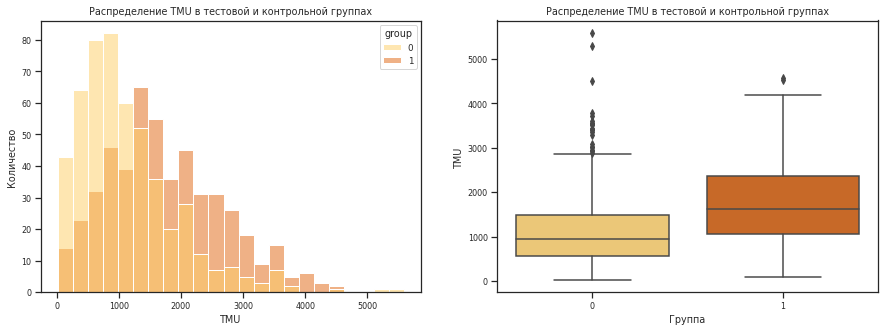

In [43]:
show_plots(df_metrics, 'TMU')

In [44]:
a, b = make_groups(df_metrics, 'TMU')
shapiro_test(a, b)

Критейрий Шапиро-Уилка
p-value контрольной группы = 8.713836969217895e-19
p-value тестовой группы = 1.408598961916141e-07

Критейрий Шапиро-Уилка прологарифмированных выборок (без учёта нулевых значений)
p-value контрольной группы = 7.013428171553926e-10
p-value тестовой группы = 2.724891650548165e-15


Уровень значимости критерия Шапиро-Уилка ниже заранее заданного уровня значимости **α** (0.05), что позволяет нам отвергнуть нулевую гипотезу H0 о нормальности распределения метрики **TMU**. Для определения наличия статистически значимых различий между группами, мы будем использовать критерий Манна-Уитни.

In [45]:
mannwhitneyu(a, b)

MannwhitneyuResult(statistic=75129.5, pvalue=3.683319309039453e-30)

Уровень значимости, полученный с помощью критерия Манна-Уитни меньше выбранного уровня значимости α (0.05), что позволяет нам отклонить нулевую гипотезу H0. 

In [46]:
metric_difference(df_metrics, 'TMU')

674.4000000000002, 70.57 %


Также посчитает, сколько прибыли нам принесли пользователи из тестовой и контрольной групп

In [47]:
df_metrics.groupby('group').TMU.sum()

group
0    583455.9
1    878628.4
Name: TMU, dtype: float64

### Вывод:
Уровень значимости, полученный с помощью критерия Манна-Уитни меньше выбранного уровня значимости α (0.05), что позволяет нам отклонить нулевую гипотезу H0. Таким образом, между тестовой и контрольной группами есть статистически значимые различия. 

Среднее количество прибыли от одного пользователя увеличилось на 674.4 пункта (**70.57 %**)

### Метрика DUOC

Введём метрику количества уникальных пользователей, создающих заказ в день Daily Unique Order Creators (**DUOC**)

**H0** - нет статистически значимых различий в количестве уникальных пользователей, создающих заказ в день между тестовой и контрольной группами.

**H1** -  существуют статистически значимые различия в количестве уникальных пользователей, создающих заказ в день между тестовой и контрольной группами.

Уровень значимости **α** = 0.05

In [48]:
df_DUOC = df_users.query('action == "create_order"')\
                  .groupby(['group', 'date'], as_index=False)\
                  .agg(DUOC=('user_id', lambda x: np.size(x.unique())))
df_DUOC.index = df_DUOC['date']
df_DUOC.drop('date', inplace=True, axis=1)
df_DUOC_group_0 = df_DUOC.query('group == 0').resample('D').sum()
df_DUOC_group_0['group'] = 0
df_DUOC_group_1 = df_DUOC.query('group == 1').resample('D').sum()
df_DUOC_group_1['group'] = 1
df_DUOC = pd.concat([df_DUOC_group_0.reset_index(), df_DUOC_group_1.reset_index()])

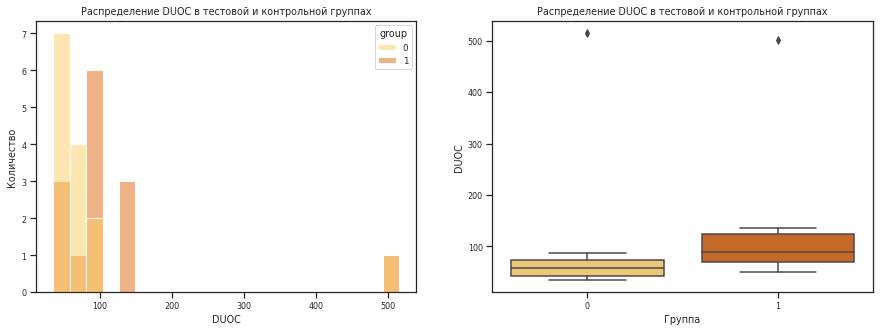

In [49]:
show_plots(df_DUOC, 'DUOC')

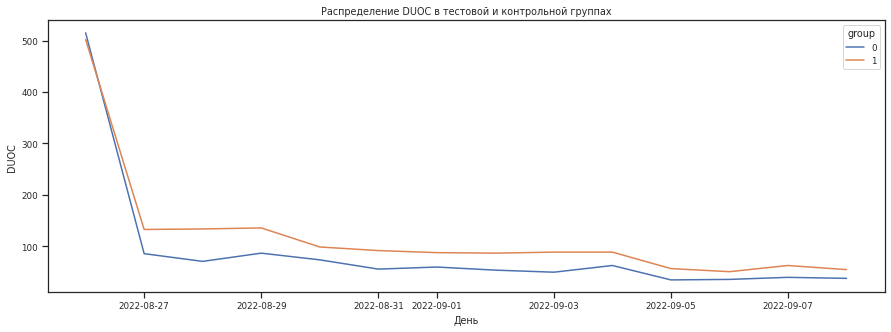

In [50]:
ax = sns.lineplot(data=df_DUOC, x='date', y='DUOC', hue='group')
ax.set_title(f'Распределение DUOC в тестовой и контрольной группах')
ax.set_xlabel('День')
ax.set_ylabel('DUOC')
plt.show()

In [51]:
a, b = make_groups(df_DUOC, 'DUOC')
shapiro_test(a, b)

Критейрий Шапиро-Уилка
p-value контрольной группы = 1.6206705595323e-06
p-value тестовой группы = 9.366684935230296e-06

Критейрий Шапиро-Уилка прологарифмированных выборок (без учёта нулевых значений)
p-value контрольной группы = 0.0008287479286082089
p-value тестовой группы = 0.007878375239670277


Уровень значимости критерия Шапиро-Уилка ниже заранее заданного уровня значимости α (0.05), что позволяет нам отвергнуть нулевую гипотезу H0. Однако, отличия от нормальности не велики, поэтому для определения наличия статистически значимых различий между группами, будем использовать t-тест прологарифмированных значений метрики DUOC

In [52]:
ttest_ind(np.log(a), np.log(b)).pvalue

0.09497126441088212

### Вывод:
Уровни значимости, полученные с помощью критерия t-Стьюдента больше выбранного уровня значимости α (0.05), что не позволяет нам отклонить нулевую гипотезу H0. Таким образом, между тестовой и контрольной группами нет статистически значимых различий в количестве уникальных пользователей, создающих заказ в день.

### Метрика RCC

Введём метрику отношения количества отменённых заказов к количеству созданных заказов  Ratio canceled orders to created orders (**RCC**)

In [53]:
df_RCC = df_users.groupby(['group', 'user_id'], as_index=False)\
                .agg(RCC = ('action', 
                            lambda x: np.count_nonzero(x == 'cancel_order') / np.count_nonzero(x == 'create_order')))
df_metrics = df_metrics.merge(df_RCC, on=['group', 'user_id'])

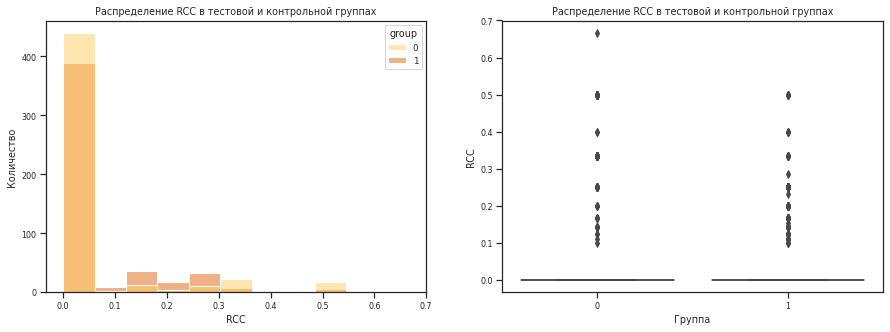

In [54]:
show_plots(df_metrics, 'RCC')

In [55]:
a, b = make_groups(df_metrics, 'RCC')

In [56]:
shapiro_test(a, b)

Критейрий Шапиро-Уилка
p-value контрольной группы = 1.9520757989230035e-37
p-value тестовой группы = 6.681989730541308e-34

Критейрий Шапиро-Уилка прологарифмированных выборок (без учёта нулевых значений)
p-value контрольной группы = 0.00012313973275013268
p-value тестовой группы = 0.00035334614221937954


Уровни значимости критерия Шапиро-Уилка ниже заранее заданного уровня значимости α (0.05), что позволяет нам отвергнуть нулевую гипотезу H0 о нормальности распределений. Для определения наличия статистически значимых различий между группами, будем использовать критерий Манна-Уитни

In [57]:
mannwhitneyu(a, b)

MannwhitneyuResult(statistic=119663.5, pvalue=0.006151142573166951)

### Вывод:
Уровень значимости, полученные с помощью критерия Манна-Уитни больше выбранного уровня значимости α (0.05), что позволяет не отклонять нулевую гипотезу H0. Таким образом, между тестовой и контрольной группами нет статистически значимых различий отношений количества отменённых заказов к количеству созданных заказов. 

## Выводы по проекту:
    
1. Имеются статистически значимые различия в количестве заказов на одного пользователя между тестовой и контрольной группами. Наблюдается увеличение на 2 заказа (66.67 %) на одного пользователя в тестовой группе по сравнению с контрольной. В контрольной группе был создан 1691 заказ, в тестовой - 2646.
2. Среднее количество прибыли от одного пользователя увеличилось на 674.4 пункта (70.57 %) в тестовой группе по сравнению с контрольной. Пользователи в контрольной группи создали заказы и не отменили на 583455.9, в тестовой - 878628.4
3. Среднее количество товаров, покупаемых пользователями не изменилось.
4. Между тестовой и контрольной группами нет статистически значимых различий в количестве уникальных пользователей, создающих заказ в день.
5. Между тестовой и контрольной группами нет статистически значимых различий отношений количества отменённых заказов к количеству созданных заказов.
6. Исходя из проведённого анализа в случае, если выборки являются репрезентативными, то новая система рекомендаций смогла принести пользу бизнесу и пользователям приложения.